# Olist 데이터셋 품질 분석 (EDA 자동화)

**분석 내용:**
1. 테이블별 결측치(Missing Values) 확인
2. 수치형 컬럼 기술통계(Descriptive Statistics) 출력
3. 이상치(Outliers) 식별을 위한 Boxplot 시각화

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

In [2]:
# 프로젝트 루트 경로 추가
sys.path.append(os.path.abspath('..'))

from src.data_loader import load_all_tables
from src.utils import set_korean_font

# 시각화 설정
set_korean_font()
plt.style.use('seaborn-v0_8-whitegrid')

# 데이터 로드
tables = load_all_tables(verbose=False)
print("✅ 데이터 로딩 완료")

✅ 한글 폰트 설정 완료 (Windows)
✅ 데이터 로딩 완료


### 1.  각 테이블을 개별 변수 이름에 저장

In [2]:
### 임시로 작성됨

# 1. 데이터 경로 설정
data_path = r'c:\Users\안심존_서초운영1\Documents\Woo\2025_ICB\processed'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
# 2. tables 딕셔너리에 데이터프레임 로드
tables = {}
for file in files:
    # 파일명에서 'olist_'와 '_dataset'을 제거하여 키 이름 생성 (예: olist_customers_dataset.csv -> customers)
    table_name = file.replace('olist_', '').replace('_dataset', '').replace('.csv', '')
    file_full_path = os.path.join(data_path, file)
    tables[table_name] = pd.read_csv(file_full_path)
    print(f"Loaded: {table_name} ({len(tables[table_name]):,} rows)")

Loaded: customers (99,441 rows)
Loaded: geolocation (1,000,163 rows)
Loaded: orders (95,082 rows)
Loaded: order_items (112,650 rows)
Loaded: order_payments (103,886 rows)
Loaded: order_reviews (99,224 rows)
Loaded: products (32,951 rows)
Loaded: sellers (3,095 rows)
Loaded: product_category_name_translation (71 rows)


In [3]:
# [추가] 각 테이블을 개별 변수에 저장
customers = tables['customers']
geolocation = tables['geolocation']
order_items = tables['order_items']
order_payments = tables['order_payments']
order_reviews = tables['order_reviews']
orders = tables['orders']
products = tables['products']
sellers = tables['sellers']

print("✅ 변수 할당 완료: customers, geolocation, order_items, order_payments, order_reviews, orders, products, sellers")

✅ 변수 할당 완료: customers, geolocation, order_items, order_payments, order_reviews, orders, products, sellers


## ✅ products 테이블 전처리
- products 테이블 내 전체 product_id 는 판매가 "이루어진" 상품
- 결측치 (카테고리 네임 NaN) 610개 NaN -> "unknown"으로 대체
- 나머지 메타데이터(상품설명) 컬럼 -> 0으로 치환
- 규격정보(무게 길이 등)2개 -> 중앙값으로 대체

In [4]:
# 1. 판매된 적 있는 유니크한 상품 리스트 (order_items 기준)
sold_product_ids = set(order_items['product_id'].unique())

# 2. 전체 등록된 상품 리스트 (products 기준)
all_product_ids = set(products['product_id'].unique())

# 3. 등록은 되었으나 한 번도 팔리지 않은 상품 찾기
unsold_products = all_product_ids - sold_product_ids

print(f"📦 전체 등록 상품 수: {len(all_product_ids):,d}개")
print(f"💰 판매 이력이 있는 상품 수: {len(sold_product_ids):,d}개")
print(f"👻 등록 후 한 번도 팔리지 않은 상품 수: {len(unsold_products):,d}개")

📦 전체 등록 상품 수: 32,951개
💰 판매 이력이 있는 상품 수: 32,951개
👻 등록 후 한 번도 팔리지 않은 상품 수: 0개


In [4]:
products.isna().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

In [6]:
products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000
mean,47.579527,757.213104,2.148463,2276.376802,30.814725,16.937422,23.196534
std,12.071951,637.745057,1.745732,4281.926387,16.914005,13.637175,12.078707
min,0.000000,0.000000,0.000000,0.000000,7.000000,2.000000,6.000000
25%,41.000000,326.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,584.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,961.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [8]:
## 결측치 처리

# 기존 방식 (Warning 발생)
# products['product_category_name'].fillna('unknown', inplace=True)

# 수정 방식 (권장)
products['product_category_name'] = products['product_category_name'].fillna('unknown')
products['product_name_lenght'] = products['product_name_lenght'].fillna(0)
products['product_description_lenght'] = products['product_description_lenght'].fillna(0)
products['product_photos_qty'] = products['product_photos_qty'].fillna(0)

# 수치형 데이터는 중앙값으로 채우기
products['product_weight_g'] = products['product_weight_g'].fillna(products['product_weight_g'].median())
products['product_length_cm'] = products['product_length_cm'].fillna(products['product_length_cm'].median())
products['product_height_cm'] = products['product_height_cm'].fillna(products['product_height_cm'].median())
products['product_width_cm'] = products['product_width_cm'].fillna(products['product_width_cm'].median())

In [7]:
clean_products = products.copy()

In [8]:
# 결측치 재 확인
clean_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32951 non-null  float64
 3   product_description_lenght  32951 non-null  float64
 4   product_photos_qty          32951 non-null  float64
 5   product_weight_g            32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


## ✅ orders 테이블 전처리
- orders 테이블 내, 주문상태가 'delivered'가 아닌 주문은 제거(주문취소, 배송지연 등은 분석에서 제외)
- orders_status가 'delivered'이나, 주문승인시간, 판매자 배송완료 시간, 고객 도착 시간이 null인 주문은 제거
- 파생변수 boxplot 확인결과, 음수 값 존재하여 음수값 제거
- 추후, 취소된 배송 건에 대한 사유 별도 분석 필요

### 📊 생성된 파생변수 명세서 (최종 업데이트)

| 파생변수명 | 의미 | 계산 로직 / 추출 방식 | 비즈니스 관점 |
| :--- | :--- | :--- | :--- |
| `total_delivery_time` | **총 배송 시간** | [(도착일 - 주문일).dt.days] | 전체 고객 경험 및 플랫폼 만족도 측정 |
| `seller_prep_time` | **판매자 준비 시간** | [(물류사 인계일 - 결제 승인일).dt.days] | 판매자(Seller)의 운영 효율성 및 성과 평가 |
| `pure_shipping_time` | **순수 운송 시간** | [(도착일 - 물류사 인계일).dt.days] | 물류사(Carrier)의 배송 성능 및 구간 효율 측정 |
| `delivery_accuracy` | **배송 정확도** | [(배송 예정일 - 실제 도착일).dt.days] | 고객과의 약속 이행도 및 서비스 신뢰도 파악 |
| `estimated_wait_time` | **예상 대기 시간** | [(배송 예정일 - 주문일).dt.days] | 구매 결정 시 고객이 수용한 배송 기대 수치 |
| `is_delayed` | **지연 여부** | `실제 도착일 > 배송 예정일` (지연 시 1) | 불만 고객 타겟팅 및 플랫폼 경쟁력 저해 요인 파악 |
| `delivery_speed_type` | **배송 속도 범주** | `pd.cut` (Very Fast, Normal, Slow, Very Slow) | 배송 성과별 세그먼트 분류 및 핵심 관리 대상 식별 |
| `purchase_hour` | **주문 시간대** | `order_purchase_timestamp.dt.hour` | 피크 타임 파악 및 타겟 마케팅 전략 수립 |
| `purchase_dayofweek` | **주문 요일** | `order_purchase_timestamp.dt.day_name()` | 요일별 구매 패턴 및 물류 부하량 예측 |
| `purchase_month` | **주문 월** | `order_purchase_timestamp.dt.month` | 월별 매출 트렌드 분석 및 계절성 파악 |
| `is_weekend` | **주말 여부** | `order_purchase_timestamp.dt.weekday >= 5` | 평일/주말 쇼핑 라이프스타일 비교 분석 |

In [9]:
# 기본 정보 확인
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95082 entries, 0 to 95081
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       95082 non-null  object
 1   customer_id                    95082 non-null  object
 2   order_status                   95082 non-null  object
 3   order_purchase_timestamp       95082 non-null  object
 4   order_approved_at              95082 non-null  object
 5   order_delivered_carrier_date   95082 non-null  object
 6   order_delivered_customer_date  95082 non-null  object
 7   order_estimated_delivery_date  95082 non-null  object
 8   total_delivery_time            95082 non-null  int64 
 9   seller_prep_time               95082 non-null  int64 
 10  pure_shipping_time             95082 non-null  int64 
 11  delivery_accuracy              95082 non-null  int64 
 12  estimated_wait_time            95082 non-null  int64 
 13  i

In [10]:
# 결측치 확인
orders.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
total_delivery_time              0
seller_prep_time                 0
pure_shipping_time               0
delivery_accuracy                0
estimated_wait_time              0
is_delayed                       0
purchase_hour                    0
purchase_dayofweek               0
purchase_month                   0
is_weekend                       0
delivery_speed_type              0
dtype: int64

In [ ]:
orders = orders[orders['order_status'] == 'delivered'].copy()

In [ ]:
orders.dropna(inplace=True)
orders.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [66]:
# 1. 날짜로 변환할 컬럼 리스트 정의
date_columns = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]
# 2. 반복문을 사용하여 각 컬럼을 datetime 형식으로 변환
for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])
# 3. 변환 결과 확인 (dtype이 datetime64로 바뀌었는지 확인)
print(orders[date_columns].dtypes)

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


In [11]:
# 주문 상태 범주 확인
orders['order_status'].value_counts()

order_status
delivered    95082
Name: count, dtype: int64

In [ ]:
# 1. 시계열 기반 파생변수 생성 (성능 및 대기 관점)
# 총 배송 시간 (주문 ~ 수령)
orders['total_delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
# 판매자 준비 시간 (승인 ~ 물류사 인계)
orders['seller_prep_time'] = (orders['order_delivered_carrier_date'] - orders['order_approved_at']).dt.days
# 순수 운송 시간 (물류사 인계 ~ 수령)
orders['pure_shipping_time'] = (orders['order_delivered_customer_date'] - orders['order_delivered_carrier_date']).dt.days
# 배송 정확도 (예정일 - 실제수령일) : 양수면 조기, 음수는 지연
orders['delivery_accuracy'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']).dt.days
# 심리적 예상 대기 시간 (예정일 - 주문일)
orders['estimated_wait_time'] = (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']).dt.days
# 지연 여부 (지연이면 1, 아니면 0)
orders['is_delayed'] = (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']).astype(int)
# 2. 시간대/요일 파생변수 생성 (고객 행동 관점)
orders['purchase_hour'] = orders['order_purchase_timestamp'].dt.hour
orders['purchase_dayofweek'] = orders['order_purchase_timestamp'].dt.day_name()
orders['purchase_month'] = orders['order_purchase_timestamp'].dt.month
orders['is_weekend'] = orders['order_purchase_timestamp'].dt.weekday >= 5
# 3. 배송 속도 범주화를 위한 기술통계 확인
print("📊 [Total Delivery Time] Descriptive Statistics")
display(orders['total_delivery_time'].describe())

📊 [Total Delivery Time] Descriptive Statistics


count    96455.000000
mean        12.093100
std          9.551209
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: total_delivery_time, dtype: float64

In [67]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95082 entries, 0 to 95081
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       95082 non-null  object        
 1   customer_id                    95082 non-null  object        
 2   order_status                   95082 non-null  object        
 3   order_purchase_timestamp       95082 non-null  datetime64[ns]
 4   order_approved_at              95082 non-null  datetime64[ns]
 5   order_delivered_carrier_date   95082 non-null  datetime64[ns]
 6   order_delivered_customer_date  95082 non-null  datetime64[ns]
 7   order_estimated_delivery_date  95082 non-null  datetime64[ns]
 8   total_delivery_time            95082 non-null  int64         
 9   seller_prep_time               95082 non-null  int64         
 10  pure_shipping_time             95082 non-null  int64         
 11  delivery_accura

In [ ]:
orders.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
total_delivery_time              0
seller_prep_time                 0
pure_shipping_time               0
delivery_accuracy                0
estimated_wait_time              0
is_delayed                       0
purchase_hour                    0
purchase_dayofweek               0
purchase_month                   0
is_weekend                       0
dtype: int64

📊 배송 속도별 주문 비중
delivery_speed_type
Very Fast    26.696956
Normal       49.033466
Slow         19.954355
Very Slow     4.315223
Name: proportion, dtype: float64


C:\Users\안심존_서초운영1\AppData\Local\Temp\ipykernel_14856\644675948.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=orders, x='delivery_speed_type', palette='viridis')


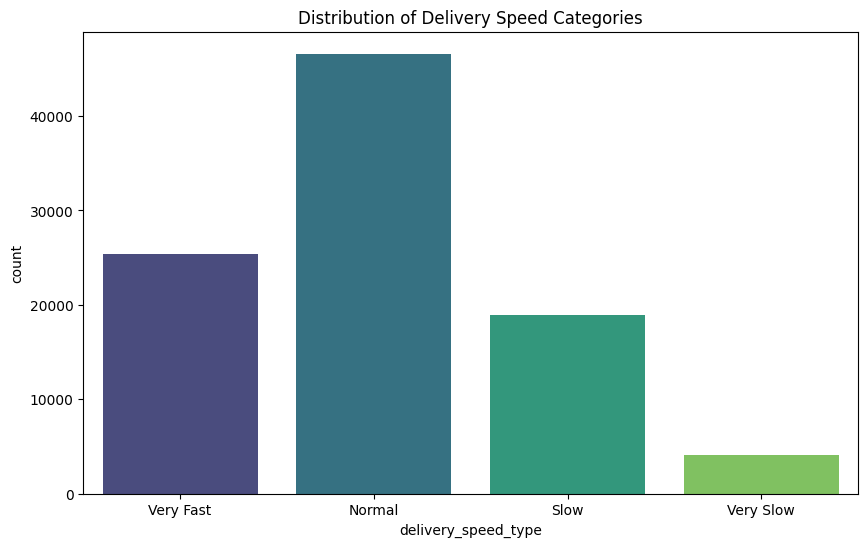

In [13]:
# 구간 경계 설정 (0, 6, 15, 30, 최대값)
bins = [-1, 6, 15, 30, orders['total_delivery_time'].max()]
labels = ['Very Fast', 'Normal', 'Slow', 'Very Slow']

# 배송 속도 범주화 컬럼 생성
orders['delivery_speed_type'] = pd.cut(orders['total_delivery_time'], bins=bins, labels=labels)

# 결과 확인 (범주별 비중)
print("📊 배송 속도별 주문 비중")
print(orders['delivery_speed_type'].value_counts(normalize=True).sort_index() * 100)

# 시각화 (Countplot)
plt.figure(figsize=(10, 6))
sns.countplot(data=orders, x='delivery_speed_type', palette='viridis')
plt.title('Distribution of Delivery Speed Categories')
plt.show()

In [ ]:
# 1. 음수 데이터(논리적 오류) 식별을 위한 조건 설정
# 총 배송 시간, 판매자 준비 시간, 순수 운송 시간은 0보다 작을 수 없습니다.
mask_logical_error = (orders['total_delivery_time'] < 0) | \
                     (orders['seller_prep_time'] < 0) | \
                     (orders['pure_shipping_time'] < 0)

# 2. 오류 데이터 개수 확인
error_count = mask_logical_error.sum()
print(f"🚩 제거할 음수 데이터 건수: {error_count}건")

# 3. 음수 데이터 제외 및 데이터프레임 갱신
# (원본을 보존하고 싶다면 orders_cleaned = orders[~mask_logical_error].copy() 사용)
orders = orders[~mask_logical_error].copy()

print(f"✅ 필터링 완료. 현재 남은 데이터 건수: {len(orders):,d}건")

🚩 제거할 음수 데이터 건수: 1373건
✅ 필터링 완료. 현재 남은 데이터 건수: 95,082건


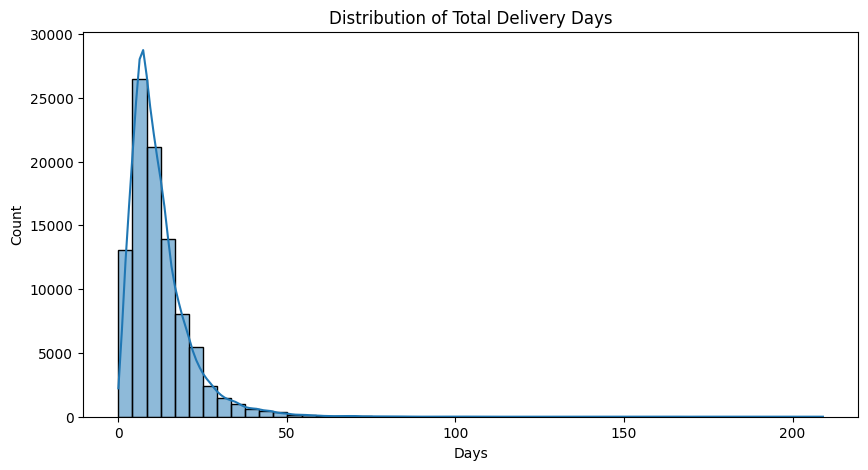

In [14]:
# 시각적으로 분포 확인 (이상치 제외하고 30일 이내 분포 위주)
plt.figure(figsize=(10, 5))
sns.histplot(orders['total_delivery_time'].dropna(), bins=50, kde=True)
plt.title('Distribution of Total Delivery Days')
plt.xlabel('Days')
plt.show()

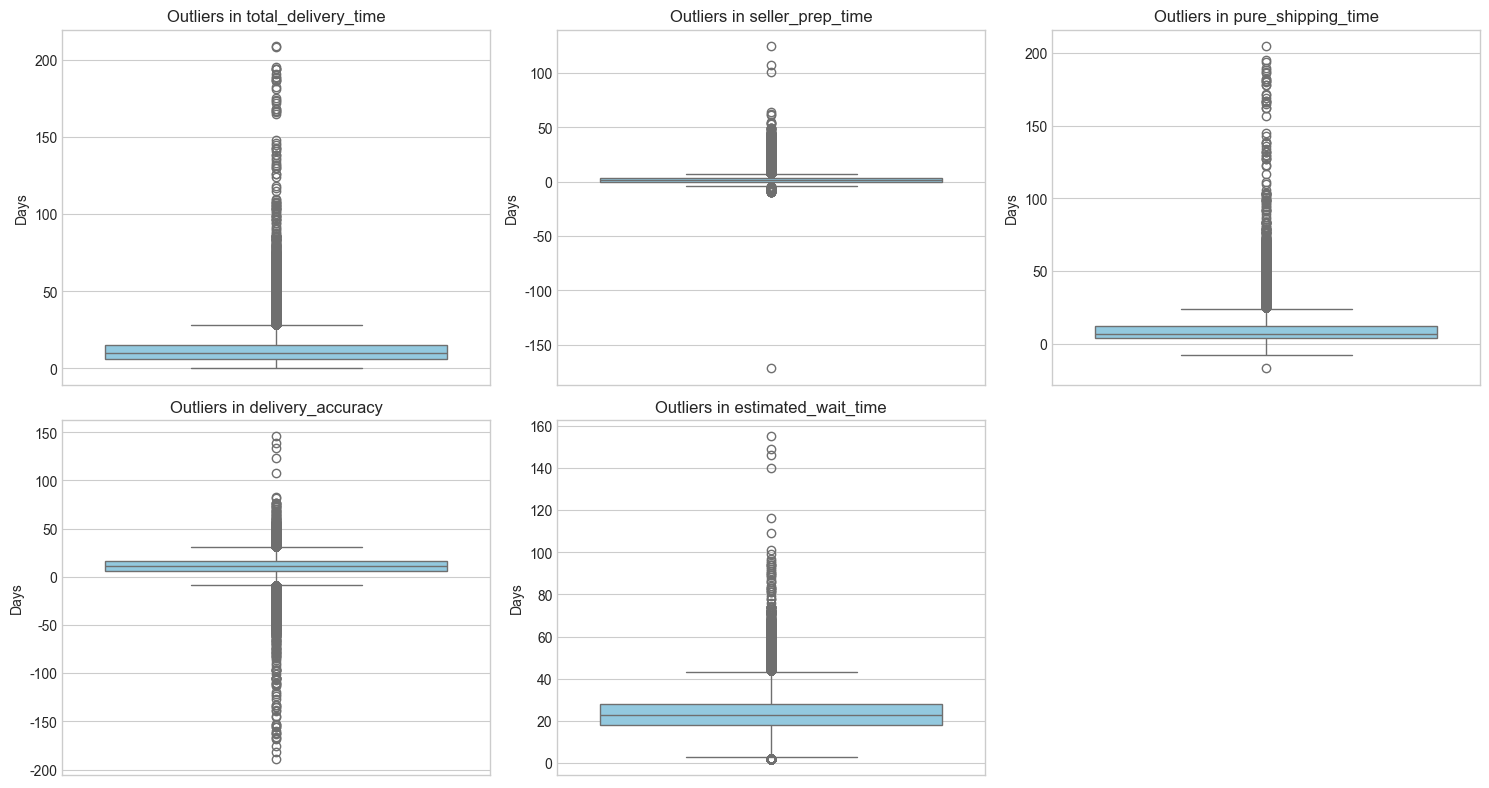

📌 주요 파생변수의 상위 1% (그 이상의 값은 극단적 이상치 가능성)


total_delivery_time    46.0
seller_prep_time       17.0
pure_shipping_time     40.0
delivery_accuracy      35.0
estimated_wait_time    50.0
Name: 0.99, dtype: float64

In [ ]:
# 1. 시각화할 수치형 파생변수 리스트 선정
# (날짜와 요일 등 범주형 성격 리스트는 제외)
numeric_derived_cols = [
    'total_delivery_time', 
    'seller_prep_time', 
    'pure_shipping_time', 
    'delivery_accuracy', 
    'estimated_wait_time'
]

# 2. 그래프 레이아웃 설정
plt.figure(figsize=(15, 8))

# 3. 반복문을 이용해 각 컬럼의 Boxplot 출력
for i, col in enumerate(numeric_derived_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=orders[col].dropna(), color='skyblue')
    plt.title(f'Outliers in {col}')
    plt.ylabel('Days')

plt.tight_layout()
plt.show()

# 4. (참고) 이상치 값을 요약해서 출력하기 (상위 99% 컷오프 지점 확인)
print("📌 주요 파생변수의 상위 1% (그 이상의 값은 극단적 이상치 가능성)")
display(orders[numeric_derived_cols].quantile(0.99))

In [15]:
# 예상 대기 기간(배송) 기술통계 확인
orders['estimated_wait_time'].describe()

count    95082.000000
mean        23.381281
std          8.762555
min          2.000000
25%         18.000000
50%         23.000000
75%         28.000000
max        155.000000
Name: estimated_wait_time, dtype: float64

In [68]:
clean_orders = orders.copy()

## ✅ orders_payments 테이블 전처리
- 별도 이상치 및 결측치 없음 으로 종결

In [17]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [18]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [19]:
order_payments[order_payments['payment_sequential'] > 1]['payment_type'].value_counts()

payment_type
voucher        4154
credit_card     319
debit_card       52
boleto            1
Name: count, dtype: int64

In [20]:
# 1. 결제 순번이 가장 높은(29) 주문의 order_id 찾기
max_seq_order = order_payments[order_payments['payment_sequential'] == 29]['order_id'].values[0]

# 2. 해당 주문의 전체 결제 내역 확인
target_order_payments = order_payments[order_payments['order_id'] == max_seq_order].sort_values('payment_sequential')

print(f"🚩 29번 분할 결제된 주문 ID: {max_seq_order}")
display(target_order_payments)

🚩 29번 분할 결제된 주문 ID: fa65dad1b0e818e3ccc5cb0e39231352


,order_id,payment_sequential,payment_type,payment_installments,payment_value
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
65641,fa65dad1b0e818e3ccc5cb0e39231352,3,voucher,1,2.95
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
82593,fa65dad1b0e818e3ccc5cb0e39231352,7,voucher,1,0.32
68853,fa65dad1b0e818e3ccc5cb0e39231352,8,voucher,1,26.02
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86


C:\Users\안심존_서초운영1\AppData\Local\Temp\ipykernel_14856\3728392182.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['short_order_id'] = df_top['order_id'].str[:8]
C:\Users\안심존_서초운영1\AppData\Local\Temp\ipykernel_14856\3728392182.py:24: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\안심존_서초운영1\AppData\Local\Temp\ipykernel_14856\3728392182.py:24: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\안심존_서초운영1\AppData\Local\Temp\ipykernel_14856\3728392182.py:24: UserWarning: Glyph 50526 (\N{HANGUL SYLLABLE AP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\안심존_서초운영1\AppData\Local\Temp\ipykernel_1485

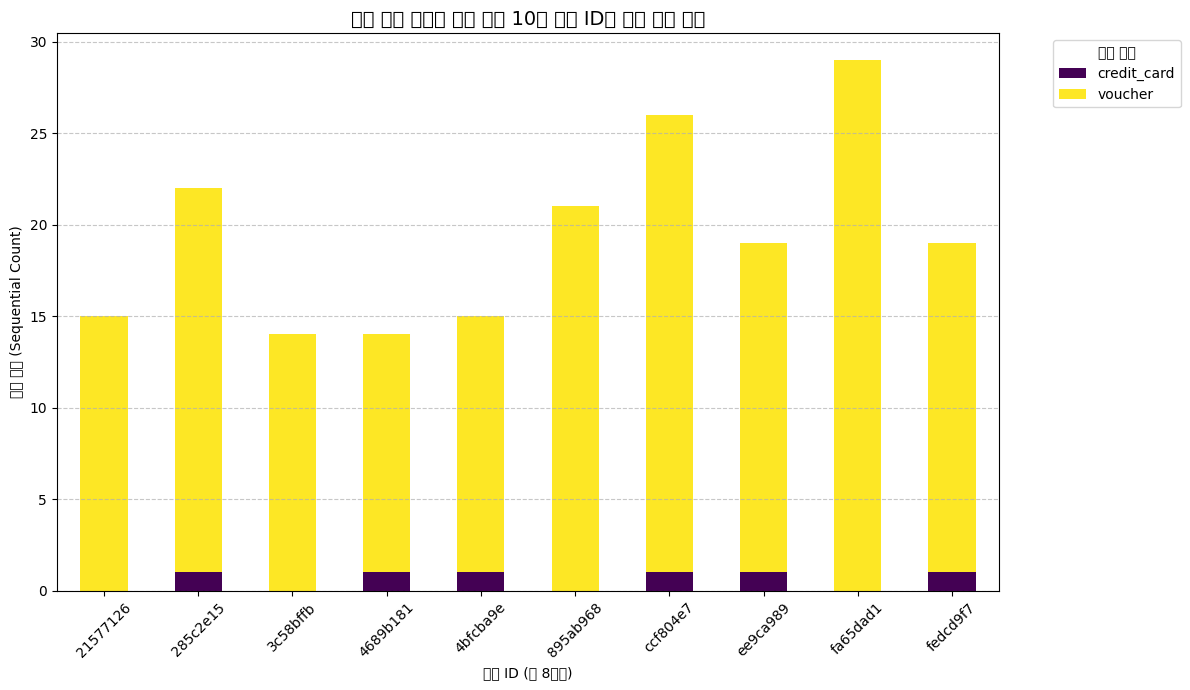

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 주문 ID별 결제 횟수 계산 및 상위 10개 주문 ID 추출
top_orders = order_payments.groupby('order_id')['payment_sequential'].max().sort_values(ascending=False).head(10).index

# 2. 상위 10개 주문에 해당하는 데이터만 필터링
df_top = order_payments[order_payments['order_id'].isin(top_orders)]

# 3. 주문 ID와 결제 타입을 기준으로 피벗 테이블 생성 (막대 그래프용)
# 주문 ID를 짧게 보여주기 위해 앞 8자리만 슬라이싱 (가독성 목적)
df_top['short_order_id'] = df_top['order_id'].str[:8]
pivot_df = df_top.groupby(['short_order_id', 'payment_type']).size().unstack().fillna(0)

# 4. 시각화 (누적 막대 그래프)
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')

plt.title('분할 결제 건수가 많은 상위 10개 주문 ID별 결제 수단 구성', fontsize=14)
plt.xlabel('주문 ID (앞 8자리)')
plt.ylabel('결제 횟수 (Sequential Count)')
plt.legend(title='결제 수단', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [45]:
clean_order_payments = order_payments.copy()

## ✅ sellers 테이블 전처리
- 별도 이상치 및 결측치 없음 으로 종결

In [23]:
clean_sellers = sellers.copy()

## ✅ order_items 테이블 전처리
- order_item_id : 1번 주문에 몇개의 상품을 주문하였는지
- shipping_limit_date : 판매자 -> 물류센터 배송 마감 기한
- 별도 결측치 및 이상치 없음으로 종결

In [ ]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [ ]:
order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


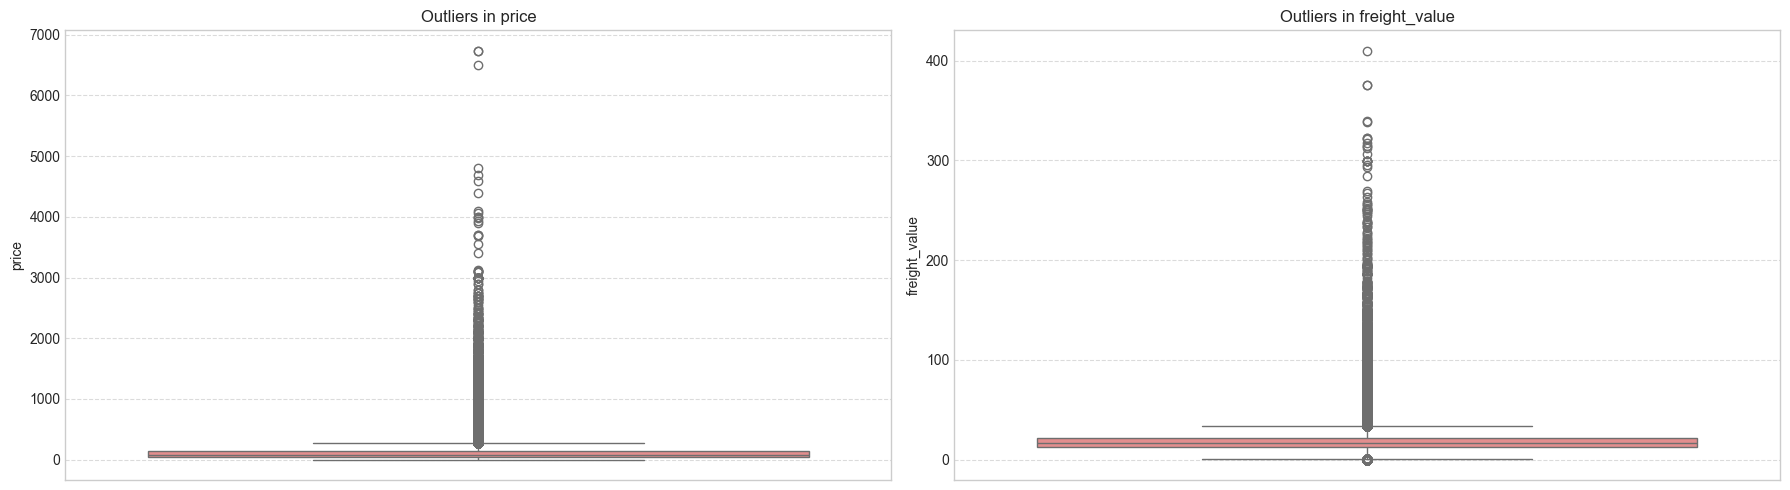

📌 결제 관련 변수들의 상위 1% 임계치:


price            890.00
freight_value     84.52
Name: 0.99, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 시각화할 수치형 컬럼 리스트
payment_cols = ['price', 'freight_value']

# 2. 그래프 레이아웃 설정 (1행 3열)
plt.figure(figsize=(18, 5))

# 3. 반복문을 이용한 Boxplot 출력
for i, col in enumerate(payment_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(y=order_items[col], color='lightcoral')
    plt.title(f'Outliers in {col}', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 4. 수치상으로도 이상치 확인 (상위 99% 값)
print("📌 결제 관련 변수들의 상위 1% 임계치:")
display(order_items[payment_cols].quantile(0.99))

In [ ]:
# 1. 주문별 아이템 총액(가격 + 배송비) 계산
items_total = order_items.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum'
}).reset_index()
items_total['items_total_sum'] = items_total['price'] + items_total['freight_value']

# 2. 주문별 실제 결제 총액 합산
payments_total = order_payments.groupby('order_id')['payment_value'].sum().reset_index()

# 3. 두 데이터 병합
validation_df = pd.merge(items_total, payments_total, on='order_id')

# 4. 차액 계산 (소수점 오차 고려)
validation_df['diff'] = validation_df['items_total_sum'] - validation_df['payment_value']

# 5. 결과 확인 (차액이 거의 0인 행의 비율 확인)
accurate_match = validation_df[abs(validation_df['diff']) < 0.1]
print(f"✅ 금액이 일치하는 주문 비율: {(len(accurate_match) / len(validation_df)) * 100:.2f}%")

# 차이가 나는 케이스가 있다면 확인 (보통 바우처나 반올림 이슈)
display(validation_df[abs(validation_df['diff']) >= 0.1].head())

✅ 금액이 일치하는 주문 비율: 99.74%


,order_id,price,freight_value,items_total_sum,payment_value,diff
165,00789ce015e7e5791c7914f32bb4fad4,154.00,14.83,168.83,190.81,-21.98
525,016726239765c18f66826453f39c64e3,219.99,15.14,235.13,265.77,-30.64
724,01e51b7c3025655646143d09b911e1d7,19.00,14.10,33.10,35.02,-1.92
965,028aa7c930356788f861ed1b7f984819,39.90,17.63,57.53,62.94,-5.41
1123,02f4dd90ba0feb8ec394cac05862d2b5,79.90,51.06,130.96,141.65,-10.69


In [24]:
clean_order_items = order_items.copy()

## ✅ order_customers 테이블 전처리
- 별도 이상치 및 결측치 없음 으로 종결

In [26]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [25]:
clean_order_customers = customers.copy()

## ✅ order_reviews 테이블 전처리
- 별도 이상치 없음 으로 종결
- 결측치 코멘트 및 제목 수용

In [27]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [28]:
# 2개 이상의 리뷰가 달린 주문 ID 리스트
multiple_review_orders = order_reviews.groupby('order_id')['review_id'].count()
multiple_review_orders = multiple_review_orders[multiple_review_orders > 1].index

# 해당 주문들의 실제 리뷰 내용 확인
order_reviews[order_reviews['order_id'].isin(multiple_review_orders)].sort_values(by='order_id')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25 00:00:00,2017-08-29 21:45:57
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22 00:00:00,2018-02-23 12:12:30
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04 00:00:00,2018-03-05 17:02:00
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:06
...,...,...,...,...,...,...,...
27465,5e78482ee783451be6026e5cf0c72de1,ff763b73e473d03c321bcd5a053316e8,3,NaN,Não sei que haverá acontecido os demais chegaram,2017-11-18 00:00:00,2017-11-18 09:02:48
41355,39de8ad3a1a494fc68cc2d5382f052f4,ff850ba359507b996e8b2fbb26df8d03,5,NaN,Envio rapido... Produto 100%,2017-08-16 00:00:00,2017-08-17 11:56:55
18783,80f25f32c00540d49d57796fb6658535,ff850ba359507b996e8b2fbb26df8d03,5,NaN,"Envio rapido, produto conforme descrito no anu...",2017-08-22 00:00:00,2017-08-25 11:40:22
92230,870d856a4873d3a67252b0c51d79b950,ffaabba06c9d293a3c614e0515ddbabc,3,NaN,NaN,2017-12-20 00:00:00,2017-12-20 18:50:16


In [29]:
# 모든 컬럼 내용이 완전히 똑같은 중복 데이터가 있는지 확인
system_dupes = order_reviews[order_reviews.duplicated()]
print(f"완전 중복 행 수: {len(system_dupes)}")

완전 중복 행 수: 0


In [30]:
# 주문당 서로 다른 review_id가 몇 개인지 확인
# "데이터가 총 몇 줄이야?" → count()
# "중복 빼고 종류가 몇 개야?" → nunique()
order_review_counts = order_reviews.groupby('order_id')['review_id'].nunique().value_counts()
print(order_review_counts)

review_id
1    98126
2      543
3        4
Name: count, dtype: int64


In [31]:
# 1. 리뷰와 고객 테이블 Join (orders 테이블 거쳐서)
merged = order_reviews.merge(orders, on='order_id').merge(customers, on='customer_id')

# 2. 동일 인물(unique_id)이 남긴 총 리뷰 수 확인
user_review_stats = merged.groupby('customer_unique_id')['review_id'].count().value_counts().sort_index()
print("동일 고객(사람)별 총 리뷰 작성 건수 분포:")
print(user_review_stats)

동일 고객(사람)별 총 리뷰 작성 건수 분포:
review_id
1     88632
2      2283
3       360
4       113
5        23
6        11
7         5
9         1
15        1
Name: count, dtype: int64


In [32]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [33]:
# 1. 주문당 상품 수 집계
items_per_order = order_items.groupby('order_id')['product_id'].count().reset_index()
items_per_order.columns = ['order_id', 'item_count']

# 2. 주문당 리뷰 수 집계
reviews_per_order = order_reviews.groupby('order_id')['review_id'].count().reset_index()
reviews_per_order.columns = ['order_id', 'review_count']

# 3. 두 데이터 합치기
check_df = pd.merge(reviews_per_order, items_per_order, on='order_id', how='left')

# 4. 리뷰가 2개 이상인 건들만 필터링해서 상품 수 확인
multi_review_case = check_df[check_df['review_count'] > 1]
print("리뷰 2개 이상인 주문의 상품 수 분포:")
print(multi_review_case['item_count'].value_counts())

리뷰 2개 이상인 주문의 상품 수 분포:
item_count
1.0     469
2.0      56
3.0      10
4.0       6
6.0       2
11.0      1
Name: count, dtype: int64


In [34]:
# 상품 1개 - 리뷰 2개인 주문 중 하나 샘플 확인
sample_order = multi_review_case[multi_review_case['item_count'] == 1]['order_id'].iloc[0]
order_reviews[order_reviews['order_id'] == sample_order]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25 00:00:00,2017-08-29 21:45:57
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12


In [35]:
order_reviews['order_id'].nunique()

98673

In [36]:
# 생성 시간 > 답변 시간인 논리적 오류 데이터 추출
time_logic_errors = order_reviews[order_reviews['review_creation_date'] > order_reviews['review_answer_timestamp']]
print(f"🚩 논리적 시점 오류 건수: {len(time_logic_errors)}건")
if len(time_logic_errors) > 0:
    display(time_logic_errors[['review_id', 'order_id', 'review_creation_date', 'review_answer_timestamp']].head())

🚩 논리적 시점 오류 건수: 0건


In [37]:
# 1. 날짜(review_creation_date)를 기준으로 내림차순 정렬 (최신이 위로 오게)
# 만약 답변 시간까지 고려하려면 'review_answer_timestamp'를 써도 됩니다.
order_reviews_sorted = order_reviews.sort_values(by='review_creation_date', ascending=False)

# 2. order_id 기준 중복 제거, 첫 번째(가장 최신) 것만 유지
order_reviews_cleaned = order_reviews_sorted.drop_duplicates(subset='order_id', keep='first')

# 3. 결과 확인
final_order_count = order_reviews_cleaned['order_id'].nunique()
final_row_count = len(order_reviews_cleaned)

print(f"고유 주문 수: {final_order_count}")
print(f"정제 후 리뷰 행 수: {final_row_count}")

if final_order_count == final_row_count:
    print("✅ 성공: 모든 주문이 1개의 리뷰만 가지도록 정제되었습니다.")

고유 주문 수: 98673
정제 후 리뷰 행 수: 98673
✅ 성공: 모든 주문이 1개의 리뷰만 가지도록 정제되었습니다.


In [38]:
# 주문당 서로 다른 review_id가 몇 개인지 최종 확인
order_review_counts = order_reviews_cleaned.groupby('order_id')['review_id'].nunique().value_counts()
print(order_review_counts)

review_id
1    98673
Name: count, dtype: int64


In [39]:
clean_order_reviews = order_reviews_cleaned.copy()

## ✅ geolocation 테이블 전처리
- 별도 이상치 없음 으로 종결

    - 결론적으로
    주 이름(state) 분석을 하실 때는 다 브라질 안이 맞으니 걱정 없이 쓰셔도 됩니다.
    다만, 나중에 **지도 시각화(Heatmap 등)**를 하거나 배송 거리를 계산하실 때는, 그 엉뚱한 숫자로 적힌 위/경도 값들이 그래프를 찌그러뜨리거나 거리 계산을 수천 km씩 틀리게 만들 수 있으니 그때만 살짝 필터링해주시면 됩니다.

In [ ]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


🚩 브라질 외부로 추정되는 좌표 데이터: 42건


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
387565,18243,28.008978,-15.536867,bom retiro da esperanca,SP
513631,28165,41.614052,-8.411675,vila nova de campos,RJ
513643,28155,-34.586422,-58.732101,santa maria,RJ
513754,28155,42.439286,13.820214,santa maria,RJ
514429,28333,38.381672,-6.328200,raposo,RJ


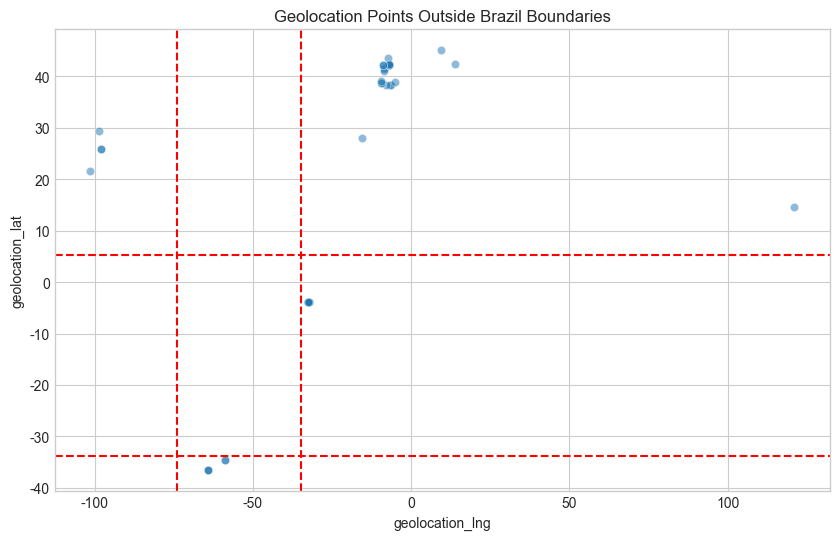

In [ ]:
geolocation# 1. 브라질 경계 설정
lat_min, lat_max = -33.75, 5.27
lng_min, lng_max = -73.98, -34.79

# 2. 범위를 벗어나는 데이터 필터링
outside_brazil = geolocation[
    (geolocation['geolocation_lat'] > lat_max) | 
    (geolocation['geolocation_lat'] < lat_min) | 
    (geolocation['geolocation_lng'] > lng_max) | 
    (geolocation['geolocation_lng'] < lng_min)
]

print(f"🚩 브라질 외부로 추정되는 좌표 데이터: {len(outside_brazil)}건")

# 3. 주요 이상치 데이터 확인
display(outside_brazil.head())

# 4. 시각화 (선택 사항: 이상치가 어디에 분포하는지 scatter plot으로 확인)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=outside_brazil, x='geolocation_lng', y='geolocation_lat', alpha=0.5)
plt.axvline(lng_min, color='red', linestyle='--')
plt.axvline(lng_max, color='red', linestyle='--')
plt.axhline(lat_min, color='red', linestyle='--')
plt.axhline(lat_max, color='red', linestyle='--')
plt.title('Geolocation Points Outside Brazil Boundaries')
plt.show()

## 전처리된 테이블 저장

In [46]:
data_list = [clean_order_customers, clean_order_items, clean_order_payments, clean_order_reviews, clean_orders, clean_products, clean_sellers, geolocation]
len(data_list)

8

In [ ]:
import os

# 1. 경로 설정
raw_dir = '../data/raw/'
processed_dir = '../data/processed/'

# 폴더가 없으면 생성
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# 2. 데이터프레임 리스트 (노트북 L1-L2 기준)
# data_list = [clean_order_customers, clean_order_items, clean_order_paymets, 
#              clean_order_reviews, clean_orders, clean_products, clean_sellers, geolocation]

# 3. 원본 파일명 리스트 (data/raw 내 파일 순서와 매칭)
# olist 데이터셋의 표준 파일명을 기반으로 작성되었습니다.
file_names = [
    'olist_customers_dataset.csv',
    'olist_order_items_dataset.csv',
    'olist_order_payments_dataset.csv',
    'olist_order_reviews_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_products_dataset.csv',
    'olist_sellers_dataset.csv',
    'olist_geolocation_dataset.csv'
]

# 4. 루프를 돌며 저장
for df, name in zip(data_list, file_names):
    # 파일명 앞에 clean_ 접두사 추가
    save_name = name
    save_path = os.path.join(processed_dir, save_name)
    
    # CSV 저장 (한글 깨짐 방지를 위해 utf-8-sig 사용)
    df.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"Saved: {save_path}")

print("\n✅ 모든 데이터가 원본 파일명에 맞춰 저장되었습니다.")

Saved: ./processed_v2\olist_customers_dataset.csv
Saved: ./processed_v2\olist_order_items_dataset.csv
Saved: ./processed_v2\olist_order_payments_dataset.csv
Saved: ./processed_v2\olist_order_reviews_dataset.csv
Saved: ./processed_v2\olist_orders_dataset.csv
Saved: ./processed_v2\olist_products_dataset.csv
Saved: ./processed_v2\olist_sellers_dataset.csv
Saved: ./processed_v2\olist_geolocation_dataset.csv

✅ 모든 데이터가 원본 파일명에 맞춰 저장되었습니다.


## 마스터 테이블 생성하기
- 마스터 테이블 1: master_orders
    - 용도: 주문/배송/리뷰/고객 경험 분석
    - 단위: 1행 = 1주문

- 마스터 테이블 2: master_sellers
    - 용도: 판매자 성과 분석
    - 단위: 1행 = 1판매자

### 마스터 테이블 1 : master_orders

In [43]:
# ==============================================
# Step 1: order_items 집계 (주문 단위)
# ==============================================
order_items_agg = (
    clean_order_items
    .groupby('order_id')
    .agg(
        item_count=('order_item_id', 'count'),
        seller_count=('seller_id', 'nunique'),
        total_price=('price', 'sum'),
        total_freight=('freight_value', 'sum')
    )
    .reset_index()
)
print(f"order_items_agg: {len(order_items_agg):,}건")

order_items_agg: 98,666건


In [47]:
# ==============================================
# Step 2: order_payments 집계 (주문 단위)
# ==============================================
# 2-1. 주 결제수단 (가장 큰 금액 기준)
payments_main = (
    clean_order_payments
    .sort_values(['order_id', 'payment_value'], ascending=[True, False])
    .drop_duplicates(subset='order_id', keep='first')
    [['order_id', 'payment_type']]
    .rename(columns={'payment_type': 'main_payment_type'})
)

In [48]:
# 2-2. 나머지 집계
payments_agg = (
    clean_order_payments
    .groupby('order_id')
    .agg(
        payment_count=('payment_sequential', 'count'),
        payment_total=('payment_value', 'sum'),
        max_installments=('payment_installments', 'max')
    )
    .reset_index()
    .merge(payments_main, on='order_id', how='left')
)

print(f"payments_agg: {len(payments_agg):,}건")

payments_agg: 99,440건


In [50]:
# ==============================================
# Step 3: 마스터 테이블 조인
# ==============================================
master_orders = (
    clean_orders
    # order_items 집계
    .merge(order_items_agg, on='order_id', how='left')
    # payments 집계
    .merge(payments_agg, on='order_id', how='left')
    # reviews (중복 제거된 것)
    .merge(
        clean_order_reviews[['order_id', 'review_score', 'review_comment_message']], 
        on='order_id', 
        how='left'
    )
    # customers
    .merge(
        clean_order_customers[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']], 
        on='customer_id', 
        how='left'
    )
)

print(f"master_orders: {len(master_orders):,}건")

master_orders: 95,082건


In [53]:
# ==============================================
# Step 4: 검증
# ==============================================
print("\n" + "="*50)
print("검증 결과")
print("="*50)

# 1. 행 수 일치
print(f"\n[1] 행 수 일치 확인")
print(f"clean_orders: {len(clean_orders):,}")
print(f"master_orders: {len(master_orders):,}")
print(f"→ 일치: {len(clean_orders) == len(master_orders)}")

# 2. 중복 확인
print(f"\n[2] order_id 중복 확인")
dup_count = master_orders['order_id'].duplicated().sum()
print(f"→ 중복 건수: {dup_count}")

# 3. 금액 검증 (수정)
print(f"\n[3] 금액 합계 검증")

# clean_orders에 있는 order_id만 필터링
valid_order_ids = clean_orders['order_id'].unique()
items_filtered = clean_order_items[clean_order_items['order_id'].isin(valid_order_ids)]

items_total = items_filtered['price'].sum()
master_total = master_orders['total_price'].sum()

print(f"order_items 총액 (필터링): {items_total:,.0f}")
print(f"master_orders 총액: {master_total:,.0f}")
print(f"→ 일치: {abs(items_total - master_total) < 1}")

# 4. 리뷰 연결 확인
print(f"\n[4] 리뷰 연결 확인")
reviews_not_null = master_orders['review_score'].notna().sum()
print(f"리뷰 있는 주문: {reviews_not_null:,}건")
print(f"리뷰 없는 주문: {master_orders['review_score'].isna().sum():,}건")

# 5. 컬럼 확인
print(f"\n[5] 컬럼 목록")
print(master_orders.columns.tolist())


검증 결과

[1] 행 수 일치 확인
clean_orders: 95,082
master_orders: 95,082
→ 일치: True

[2] order_id 중복 확인
→ 중복 건수: 0

[3] 금액 합계 검증
order_items 총액 (필터링): 13,043,202
master_orders 총액: 13,043,202
→ 일치: True

[4] 리뷰 연결 확인
리뷰 있는 주문: 94,443건
리뷰 없는 주문: 639건

[5] 컬럼 목록
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'total_delivery_time', 'seller_prep_time', 'pure_shipping_time', 'delivery_accuracy', 'estimated_wait_time', 'is_delayed', 'purchase_hour', 'purchase_dayofweek', 'purchase_month', 'is_weekend', 'delivery_speed_type', 'item_count', 'seller_count', 'total_price', 'total_freight', 'payment_count', 'payment_total', 'max_installments', 'main_payment_type', 'review_score', 'review_comment_message', 'customer_unique_id', 'customer_city', 'customer_state']


In [52]:
# 리뷰 없는 주문 확인
no_review_orders = master_orders[master_orders['review_score'].isna()]['order_id']

# 원본 리뷰에 있는지 확인
in_original = clean_order_reviews['order_id'].isin(no_review_orders).sum()
print(f"원본 리뷰에 존재: {in_original}건")
print(f"원본에도 없음: {len(no_review_orders) - in_original}건")

원본 리뷰에 존재: 0건
원본에도 없음: 639건


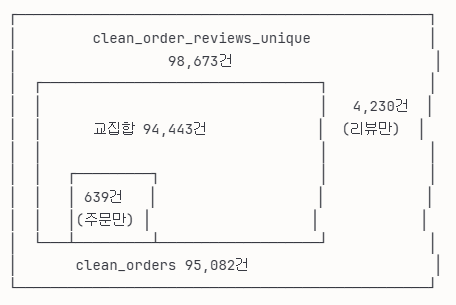

### 마스터 테이블 2 : master_sellers

In [70]:
# ==============================================
# Step 1: 주문-판매자 중간 집계
# ==============================================
# 1주문에 여러 판매자 → (order_id, seller_id) 단위 먼저 집계

order_seller = (
    clean_order_items
    .groupby(['order_id', 'seller_id'])
    .agg(
        items_in_order=('order_item_id', 'count'),
        revenue_in_order=('price', 'sum'),
        freight_in_order=('freight_value', 'sum')
    )
    .reset_index()
)

print(f"order_seller (주문-판매자 조합): {len(order_seller):,}건")

order_seller (주문-판매자 조합): 100,010건


In [71]:
# ==============================================
# Step 2: 주문 정보 붙이기
# ==============================================
order_seller = (
    order_seller
    .merge(
        clean_orders[['order_id', 'order_purchase_timestamp', 
                      'total_delivery_time', 'is_delayed']], 
        on='order_id', 
        how='left'
    )
    .merge(
        clean_order_reviews[['order_id', 'review_score']], 
        on='order_id', 
        how='left'
    )
)

In [72]:
# ==============================================
# Step 3: 판매자 단위 집계
# ==============================================
master_sellers = (
    order_seller
    .groupby('seller_id')
    .agg(
        # 주문/매출
        total_orders=('order_id', 'nunique'),
        total_items=('items_in_order', 'sum'),
        total_revenue=('revenue_in_order', 'sum'),
        total_freight=('freight_in_order', 'sum'),
        
        # 리뷰 (주문 단위 평균)
        avg_review_score=('review_score', 'mean'),
        review_count=('review_score', 'count'),
        five_star_count=('review_score', lambda x: (x == 5).sum()),
        one_star_count=('review_score', lambda x: (x == 1).sum()),
        
        # 배송
        avg_delivery_days=('total_delivery_time', 'mean'),
        delay_count=('is_delayed', 'sum'),
        
        # 기간
        first_order_date=('order_purchase_timestamp', 'min'),
        last_order_date=('order_purchase_timestamp', 'max')
    )
    .reset_index()
)

## master_sellers 파생변수 설명

| 변수명 | 계산식 | 의미 | 분석 용도 |
|--------|--------|------|-----------|
| `total_gmv` | total_revenue + total_freight | 판매자의 총 거래액. 고객이 실제 지불한 금액(상품가격 + 배송비)의 합계 | 판매자 매출 순위, 파레토 분석 (상위 20%가 전체 매출의 몇 % 차지하는지) |
| `five_star_rate` | five_star_count / review_count × 100 | 해당 판매자 주문 중 5점 리뷰를 받은 비율 (%). 높을수록 만족 고객 多 | 우수 판매자 식별, 판매자 품질 평가 |
| `one_star_rate` | one_star_count / review_count × 100 | 해당 판매자 주문 중 1점 리뷰를 받은 비율 (%). 높을수록 불만족 고객 多 | 문제 판매자 식별, 리스크 관리 대상 선정 |
| `delay_rate` | delay_count / total_orders × 100 | 해당 판매자 주문 중 배송 지연이 발생한 비율 (%). 고객이 예상 배송일보다 늦게 받은 비율 | 배송 품질 평가, 지연-리뷰 관계 분석 |

### 참고사항

| 항목 | 설명 |
|------|------|
| GMV | Gross Merchandise Value. 플랫폼에서 거래된 총 금액을 의미 |
| delay_rate 해석 | 판매자 책임 + 물류사 책임 + 외부 요인이 혼합된 최종 결과. 순수 판매자 책임만 측정한 것은 아님 |
| 비율 단위 | 모든 rate 변수는 % 단위 (0~100) |

In [73]:
# ==============================================
# Step 4: 파생 변수 추가
# ==============================================
master_sellers['total_gmv'] = master_sellers['total_revenue'] + master_sellers['total_freight']
master_sellers['five_star_rate'] = (master_sellers['five_star_count'] / master_sellers['review_count'] * 100).round(2)
master_sellers['one_star_rate'] = (master_sellers['one_star_count'] / master_sellers['review_count'] * 100).round(2)
master_sellers['delay_rate'] = (master_sellers['delay_count'] / master_sellers['total_orders'] * 100).round(2)

In [74]:
# ==============================================
# Step 5: 판매자 정보 붙이기
# ==============================================
master_sellers = master_sellers.merge(
    clean_sellers[['seller_id', 'seller_city', 'seller_state']], 
    on='seller_id', 
    how='left'
)

print(f"master_sellers: {len(master_sellers):,}건")

master_sellers: 3,095건


In [75]:
# ==============================================
# Step 6: 검증
# ==============================================
print("\n" + "="*50)
print("검증 결과")
print("="*50)

# 1. 중복 확인
print(f"\n[1] seller_id 중복 확인")
dup_count = master_sellers['seller_id'].duplicated().sum()
print(f"→ 중복 건수: {dup_count}")

# 2. 판매자 수 비교
print(f"\n[2] 판매자 수 확인")
print(f"clean_sellers: {len(clean_sellers):,}")
print(f"master_sellers: {len(master_sellers):,}")
print(f"※ 차이 = 주문 없는 판매자 (정상)")

# 3. GMV 검증
print(f"\n[3] GMV 합계 검증")
items_gmv = clean_order_items['price'].sum() + clean_order_items['freight_value'].sum()
master_gmv = master_sellers['total_gmv'].sum()
print(f"order_items GMV: {items_gmv:,.0f}")
print(f"master_sellers GMV: {master_gmv:,.0f}")
print(f"→ 일치: {abs(items_gmv - master_gmv) < 1}")

# 4. 컬럼 확인
print(f"\n[4] 컬럼 목록")
print(master_sellers.columns.tolist())


검증 결과

[1] seller_id 중복 확인
→ 중복 건수: 0

[2] 판매자 수 확인
clean_sellers: 3,095
master_sellers: 3,095
※ 차이 = 주문 없는 판매자 (정상)

[3] GMV 합계 검증
order_items GMV: 15,843,553
master_sellers GMV: 15,843,553
→ 일치: True

[4] 컬럼 목록
['seller_id', 'total_orders', 'total_items', 'total_revenue', 'total_freight', 'avg_review_score', 'review_count', 'five_star_count', 'one_star_count', 'avg_delivery_days', 'delay_count', 'first_order_date', 'last_order_date', 'total_gmv', 'five_star_rate', 'one_star_rate', 'delay_rate', 'seller_city', 'seller_state']


In [76]:
# master_orders 저장
master_orders.to_csv('master_orders.csv', index=False, encoding='utf-8-sig')

# master_sellers 저장
master_sellers.to_csv('master_sellers.csv', index=False, encoding='utf-8-sig')

print("저장 완료")
print(f"master_orders: {len(master_orders):,}건")
print(f"master_sellers: {len(master_sellers):,}건")

저장 완료
master_orders: 95,082건
master_sellers: 3,095건


In [5]:
master_orders = pd.read_csv('../data/master/master_orders.csv')
master_sellers = pd.read_csv('../data/master/master_sellers.csv')

In [6]:
print("master_orders 컬럼:")
print(master_orders.columns.tolist())

print("\nmaster_sellers 컬럼:")
print(master_sellers.columns.tolist())

master_orders 컬럼:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'total_delivery_time', 'seller_prep_time', 'pure_shipping_time', 'delivery_accuracy', 'estimated_wait_time', 'is_delayed', 'purchase_hour', 'purchase_dayofweek', 'purchase_month', 'is_weekend', 'delivery_speed_type', 'item_count', 'seller_count', 'total_price', 'total_freight', 'payment_count', 'payment_total', 'max_installments', 'main_payment_type', 'review_score', 'review_comment_message', 'customer_unique_id', 'customer_city', 'customer_state']

master_sellers 컬럼:
['seller_id', 'total_orders', 'total_items', 'total_revenue', 'total_freight', 'avg_review_score', 'review_count', 'five_star_count', 'one_star_count', 'avg_delivery_days', 'delay_count', 'first_order_date', 'last_order_date', 'total_gmv', 'five_star_rate', 'one_star_rate', 'delay_rate', 'seller_city', 'seller_state'

NameError: name 'validation_df' is not defined

In [14]:
import pandas as pd

# 1. 주문별 총 주문 금액 계산 (상품평 단가 + 배송비)
# order_items 기준
items_total = order_items.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum'
}).reset_index()
items_total['total_order_value'] = items_total['price'] + items_total['freight_value']

# 2. 주문별 총 결제 금액 계산 (카드 + 바우처 등 모든 수단 합계)
# order_payments 기준
payments_total = order_payments.groupby('order_id')['payment_value'].sum().reset_index()

# 3. 두 데이터를 하나로 병합 (validation_df 생성)
validation_df = pd.merge(items_total, payments_total, on='order_id', how='inner')

# 4. 차액(diff) 계산 (소수점 2자리까지 표시되는 화폐 특성상 0.1원 이상 차이만 필터링)
validation_df['diff'] = validation_df['total_order_value'] - validation_df['payment_value']

# 5. 불일치 주문(Mismatch)만 추출
mismatch_orders = validation_df[abs(validation_df['diff']) >= 0.1].copy()

print(f"🚩 전체 분석 대상 주문: {len(validation_df)}건")
print(f"🚩 금액 불일치 주문: {len(mismatch_orders)}건 (약 {len(mismatch_orders)/len(validation_df)*100:.2f}%)")

# 6. [핵심 검증] 불일치 주문들의 결제 수단 확인
# 불일치 주문 ID를 리스트로 만듭니다.
mismatch_ids = mismatch_orders['order_id'].tolist()

# 결제 테이블에서 불일치 주문들의 결제 타입을 가져옵니다.
mismatch_payment_types = order_payments[order_payments['order_id'].isin(mismatch_ids)]

# 7. 바우처(voucher) 사용 여부 비율 확인
voucher_usage = mismatch_payment_types[mismatch_payment_types['payment_type'] == 'voucher']
voucher_order_count = voucher_usage['order_id'].nunique()

print(f"\n📊 금액 불일치 주문 중 '바우처(Voucher)'를 사용한 주문 수: {voucher_order_count}건")
print(f"📊 불일치 원인이 바우처일 확률: {(voucher_order_count / len(mismatch_orders)) * 100:.2f}%")

# 8. 상세 샘플 확인
# 차액이 발생한 데이터 중 상위 5개를 출력하여 결제 수단과 비교
display(mismatch_orders.head())

🚩 전체 분석 대상 주문: 98665건
🚩 금액 불일치 주문: 259건 (약 0.26%)

📊 금액 불일치 주문 중 '바우처(Voucher)'를 사용한 주문 수: 7건
📊 불일치 원인이 바우처일 확률: 2.70%


,order_id,price,freight_value,total_order_value,payment_value,diff
165,00789ce015e7e5791c7914f32bb4fad4,154.00,14.83,168.83,190.81,-21.98
525,016726239765c18f66826453f39c64e3,219.99,15.14,235.13,265.77,-30.64
724,01e51b7c3025655646143d09b911e1d7,19.00,14.10,33.10,35.02,-1.92
965,028aa7c930356788f861ed1b7f984819,39.90,17.63,57.53,62.94,-5.41
1123,02f4dd90ba0feb8ec394cac05862d2b5,79.90,51.06,130.96,141.65,-10.69


In [15]:
# 불일치 주문(259건)의 결제 상세 데이터 추출
mismatch_payment_details = order_payments[order_payments['order_id'].isin(mismatch_ids)]

print("--- [불일치 주문 259건 정밀 진단] ---")

# 1. 차액의 규모 확인 (단순 반올림인가, 큰 금액인가?)
print(f"\n1. 차액(diff) 통계 정보:")
print(mismatch_orders['diff'].describe())

# 2. 결제 수단별 빈도 (바우처가 아니라면 어떤 수단인가?)
print("\n2. 불일치 주문에 쓰인 결제 수단 분포:")
print(mismatch_payment_types['payment_type'].value_counts())

# 3. 분할 결제 여부 확인 (여러 번 나눠 냈는가?)
split_counts = mismatch_payment_types.groupby('order_id').size().value_counts()
print("\n3. 주문당 결제 건수(결제 횟수) 분포:")
print(split_counts)

# 4. 할부 이자 가능성 확인 (할부 횟수가 많은가?)
print("\n4. 평균 할부 횟수:")
print(mismatch_payment_types['payment_installments'].mean())

# 5. [가장 중요] 실제 차이가 나는 샘플 10개만 자세히 보기
# 총 주문액 vs 결제액 vs 차액 vs 결제타입
sample_ids = mismatch_orders.head(10)['order_id']
sample_check = pd.merge(
    mismatch_orders[mismatch_orders['order_id'].isin(sample_ids)],
    order_payments[order_payments['order_id'].isin(sample_ids)][['order_id', 'payment_type', 'payment_installments']],
    on='order_id'
)

display(sample_check)

--- [불일치 주문 259건 정밀 진단] ---

1. 차액(diff) 통계 정보:
count    259.000000
mean     -11.085251
std       19.094554
min     -182.810000
25%      -13.705000
50%       -6.850000
75%       -2.980000
max       51.620000
Name: diff, dtype: float64

2. 불일치 주문에 쓰인 결제 수단 분포:
payment_type
credit_card    262
voucher          7
debit_card       7
Name: count, dtype: int64

3. 주문당 결제 건수(결제 횟수) 분포:
1    242
2     17
Name: count, dtype: int64

4. 평균 할부 횟수:
5.88768115942029


,order_id,price,freight_value,total_order_value,payment_value,diff,payment_type,payment_installments
0,00789ce015e7e5791c7914f32bb4fad4,154.00,14.83,168.83,190.81,-21.98,credit_card,10
1,016726239765c18f66826453f39c64e3,219.99,15.14,235.13,265.77,-30.64,credit_card,10
2,01e51b7c3025655646143d09b911e1d7,19.00,14.10,33.10,35.02,-1.92,credit_card,3
3,028aa7c930356788f861ed1b7f984819,39.90,17.63,57.53,62.94,-5.41,credit_card,6
4,02f4dd90ba0feb8ec394cac05862d2b5,79.90,51.06,130.96,141.65,-10.69,credit_card,6
5,033ccfbdfc4d29677b7e1e6df3a82820,49.00,10.96,59.96,69.26,-9.30,credit_card,3
6,033ccfbdfc4d29677b7e1e6df3a82820,49.00,10.96,59.96,69.26,-9.30,credit_card,3
7,0345ba423eed2b009e0e407b19c422e4,60.08,17.67,77.75,83.17,-5.42,credit_card,5
8,03b218d39c422c250f389120c531b61f,38.50,11.74,50.24,58.03,-7.79,credit_card,5
9,04e00ba23c33890eaee39b02e8185cc2,33.90,14.40,48.30,53.41,-5.11,credit_card,5


In [ ]:
# 데이터 품질 분석 함수
def perform_quality_check(table_name, df):
    """
    특정 테이블의 결측치, 기술통계, 이상치를 출력하는 함수
    """
    print(f"\n{'='*80}")
    print(f"🔍 ANALYSIS: [{table_name.upper()}] Table")
    print(f"{'='*80}")
    
    # 1. 결측치 (Missing Values)
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100)
    missing_df = pd.DataFrame({'Missing Count': missing, 'Ratio (%)': missing_pct})
    
    print("\n[1. 결측치 현황]")
    if missing.sum() > 0:
        display(missing_df[missing_df['Missing Count'] > 0])
    else:
        print("✅ 결측치 없음")
        
    # 2. 기술통계 (Descriptive Statistics)
    num_df = df.select_dtypes(include=[np.number])
    if not num_df.empty:
        print("\n[2. 수치형 데이터 기술통계]")
        display(num_df.describe().T)
        
        # 3. 이상치 시각화 (Boxplot)
        # 분석에 의미 있는 수치형 컬럼만 필터링 (ID, ZipCode 제외)
        plot_cols = [col for col in num_df.columns 
                     if 'zip' not in col.lower() and col != 'payment_sequential']
        
        if plot_cols:
            print(f"\n[3. 주요 컬럼 이상치 분석 - {table_name}]")
            n_cols = len(plot_cols)
            fig, axes = plt.subplots(1, n_cols, figsize=(max(4*n_cols, 12), 5))
            
            if n_cols == 1:
                sns.boxplot(y=df[plot_cols[0]], ax=axes, color='#FF9999')
                axes.set_title(plot_cols[0])
            else:
                for i, col in enumerate(plot_cols):
                    sns.boxplot(y=df[col].dropna(), ax=axes[i], color='#99FF99')
                    axes[i].set_title(col)
            
            plt.tight_layout()
            plt.show()
    else:
        print("\n[!] 수치형 컬럼이 존재하지 않습니다.")

# 모든 테이블에 대해 루프 실행
for name, df in tables.items():
    if df is not None:
        perform_quality_check(name, df)